Target Session Folder: ../data/raw/session_20250517_173425
Loaded config: FS_EEG=125, FS_PPG=25, FS_IMU=50
Active EEG channels from config: ['LF', 'RF', 'OTEL', 'OTER'] at indices [0, 1, 3, 4]
Added project root to sys.path: /Users/yamachang/Desktop/meditation_cosc
Successfully imported signal_utils functions.
Attempting to load data from: ../data/raw/session_20250517_173425
  Loaded raw_eeg.npy with shape (6, 229878)
  Loaded raw_ppg.npy with shape (3, 43968)
  Loaded raw_imu.npy with shape (3, 91950)
Trimmed EEG. New shape: (6, 214878)
Trimmed 2D PPG. New shape: (3, 40968)
Trimmed IMU. New shape: (3, 85950)
Selected/scaled active EEG. Final shape: (4, 214878)
Processing (4, 214878) EEG data through fast causal pipeline...
  Processing channel 1/4
  Processing channel 2/4
  Processing channel 3/4
  Processing channel 4/4
Processing completed in 8.56 seconds

=== Processing Statistics ===
Overall artifact rate: 3.56%
Epoch quality: 357/429 (83.2%) good epochs

Per-channel statistics:
 

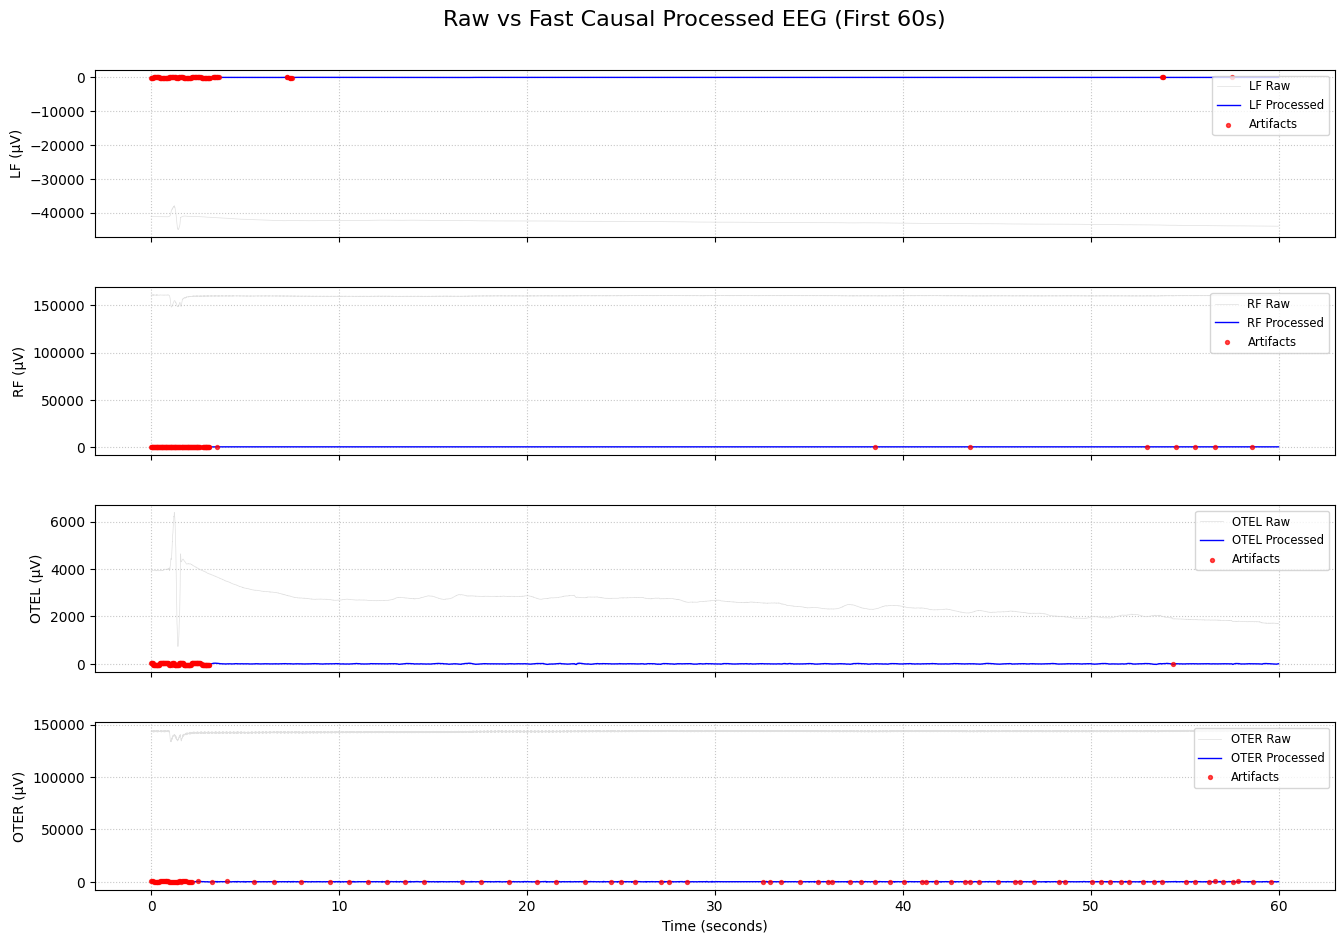

Calculating band powers for 4 channels using processed data: ['LF', 'RF', 'OTEL', 'OTER']
Band powers and T/A ratios calculated from processed data.


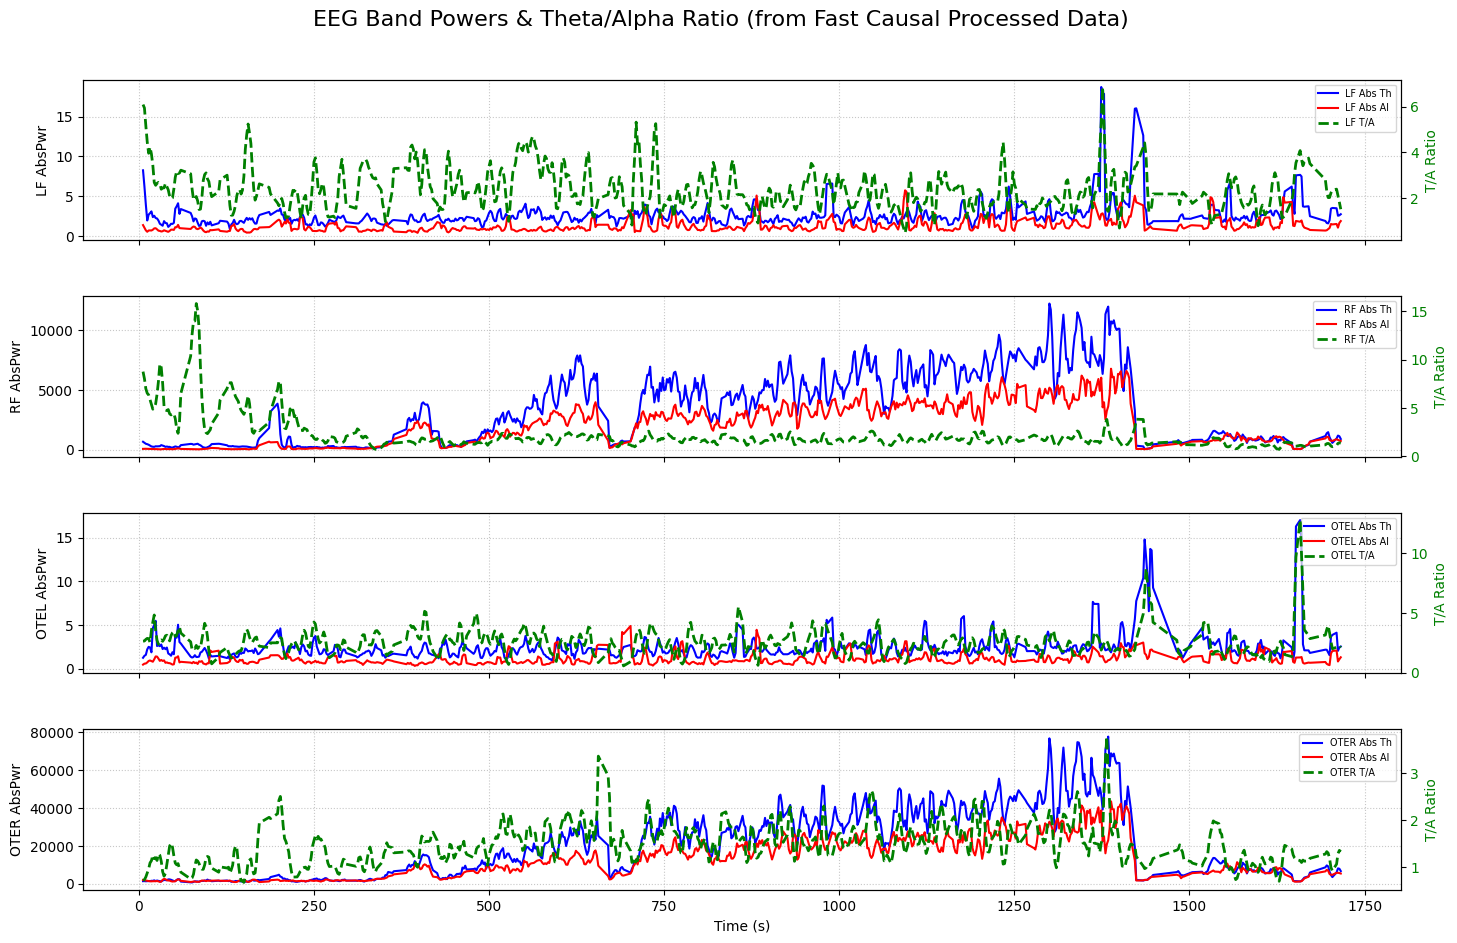

In [1]:
# Cell 1: Setup - Imports and Configuration Loading
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.axes
import os
import sys
import yaml
import pandas as pd
from collections import deque
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter, sosfilt
from IPython.display import display

# --- Matplotlib Magic Command ---
%matplotlib inline

# --- Configuration ---
# !!! ACTION REQUIRED: Set this to your specific session folder !!!
SESSION_DATA_FOLDER = "../data/raw/session_20250517_173425" # Adjust this path!
print(f"Target Session Folder: {SESSION_DATA_FOLDER}")

# --- Load Configuration from config.yaml ---
CONFIG_FILE_PATH = "../config.yaml"
try:
    with open(CONFIG_FILE_PATH, 'r') as f:
        config_yaml = yaml.safe_load(f)
    
    FS_EEG = config_yaml['signal_processing']['eeg']['sample_rate']
    FS_PPG = config_yaml['signal_processing']['ppg']['sample_rate']
    FS_IMU = config_yaml['signal_processing']['imu']['sample_rate']
    
    EEG_TOTAL_CHANNELS = config_yaml['signal_processing']['eeg']['total_channels_from_device']
    EEG_ACTIVE_INDICES = config_yaml['signal_processing']['eeg']['active_channels_indices']
    EEG_ACTIVE_NAMES = config_yaml['signal_processing']['eeg']['active_channels_names']
    eeg_settings = config_yaml['signal_processing']['eeg']
    
    print(f"Loaded config: FS_EEG={FS_EEG}, FS_PPG={FS_PPG}, FS_IMU={FS_IMU}")
    print(f"Active EEG channels from config: {EEG_ACTIVE_NAMES} at indices {EEG_ACTIVE_INDICES}")
    if len(EEG_ACTIVE_INDICES) != 4:
        print("WARNING: Config does not specify 4 active EEG channels as expected (LF,RF,OTEL,OTER).")

except FileNotFoundError:
    print(f"config.yaml not found at {CONFIG_FILE_PATH}. Using manual fallback parameters.")
    FS_EEG = 128; FS_PPG = 64; FS_IMU = 100
    EEG_TOTAL_CHANNELS = 6; EEG_ACTIVE_INDICES = [0, 1, 3, 4]; EEG_ACTIVE_NAMES = ['LF', 'RF', 'OTEL', 'OTER']
    eeg_settings = {
        'sample_rate': FS_EEG, 'active_channels_indices': EEG_ACTIVE_INDICES,
        'active_channels_names': EEG_ACTIVE_NAMES, 'eeg_uv_scaling_factor': 1.0,
        'feature_window_sec': 4, 'feature_overlap_ratio': 0.5, 'psd_nperseg_sec': 4,
        'psd_overlap_ratio': 0.5, 'notch_freq': 60.0, 'theta_band_actual': [4.0, 8.0],
        'alpha_band': [8.0, 13.0], 'total_power_reference_band': [1.0, 30.0]
    }

# --- Add project src to Python path ---
project_root_nb = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root_nb not in sys.path:
    sys.path.append(project_root_nb)
    print(f"Added project root to sys.path: {project_root_nb}")

try:
    from src.utils.signal_utils import calculate_psd_welch, calculate_band_power
    print("Successfully imported signal_utils functions.")
except ImportError as e:
    print(f"Error importing from src.utils.signal_utils: {e}. Using fallback implementations.")
    
    def calculate_psd_welch(data, fs, nperseg=None, noverlap=None):
        """Fallback PSD calculation using Welch's method"""
        if nperseg is None:
            nperseg = min(len(data), fs * 2)
        if noverlap is None:
            noverlap = nperseg // 2
        freqs, psd = signal.welch(data, fs, nperseg=nperseg, noverlap=noverlap)
        return freqs, psd
    
    def calculate_band_power(freqs, psd, band):
        """Fallback band power calculation"""
        band_indices = np.where((freqs >= band[0]) & (freqs <= band[1]))[0]
        if len(band_indices) == 0:
            return 0.0
        return np.trapz(psd[band_indices], freqs[band_indices])

# Cell 1.5: Fast Causal EEG Processor

def fast_rolling_median_mad(data, window_size, update_every=128):
    """
    Fast rolling median/MAD calculation with sparse updates
    Only recalculates every 'update_every' samples for efficiency
    """
    n_samples = len(data)
    medians = np.zeros(n_samples)
    mads = np.ones(n_samples)  # Initialize to 1
    
    # Initialize first window
    if n_samples >= window_size:
        first_window = data[:window_size]
        medians[:window_size] = np.median(first_window)
        mads[:window_size] = np.median(np.abs(first_window - medians[0]))
        if mads[0] == 0:
            mads[:window_size] = 1.0
    
    # Update at sparse intervals
    for i in range(window_size, n_samples, update_every):
        end_idx = min(i + update_every, n_samples)
        start_window = max(0, i - window_size)
        
        window_data = data[start_window:i]
        median_val = np.median(window_data)
        mad_val = np.median(np.abs(window_data - median_val))
        if mad_val == 0:
            mad_val = 1.0
        
        # Fill the interval
        medians[i:end_idx] = median_val
        mads[i:end_idx] = mad_val
    
    return medians, mads

def fast_causal_eeg_pipeline(data, fs, notch_freq=60.0, bandpass_low=1.0, bandpass_high=40.0,
                           rolling_window_sec=30.0, mad_threshold=6.0, median_filter_size=5):
    """
    Fast vectorized causal EEG processing pipeline
    
    Args:
        data: EEG data (channels x samples)
        fs: Sampling rate
        
    Returns:
        processed_data: Cleaned EEG data
        artifact_flags: Boolean array indicating artifacts
        stats: Dictionary with processing statistics
    """
    print(f"Processing {data.shape} EEG data through fast causal pipeline...")
    
    num_channels, num_samples = data.shape
    processed_data = np.zeros_like(data)
    artifact_flags = np.zeros(data.shape, dtype=bool)
    
    # Design filters
    Q = 30.0
    notch_b, notch_a = iirnotch(notch_freq, Q, fs)
    bandpass_sos = butter(4, [bandpass_low, bandpass_high], btype='band', fs=fs, output='sos')
    
    rolling_window_size = int(rolling_window_sec * fs)
    update_interval = max(1, fs // 4)  # Update stats 4 times per second
    
    channel_stats = {}
    
    for ch_idx in range(num_channels):
        print(f"  Processing channel {ch_idx+1}/{num_channels}")
        
        # Step 1: Apply causal filters
        notch_filtered = lfilter(notch_b, notch_a, data[ch_idx, :])
        bandpass_filtered = sosfilt(bandpass_sos, notch_filtered)
        
        # Step 2: Fast rolling median/MAD calculation
        medians, mads = fast_rolling_median_mad(bandpass_filtered, rolling_window_size, update_interval)
        
        # Step 3: Artifact detection and clipping
        lower_bounds = medians - mad_threshold * mads
        upper_bounds = medians + mad_threshold * mads
        
        # Find artifacts
        artifacts = (bandpass_filtered < lower_bounds) | (bandpass_filtered > upper_bounds)
        artifact_flags[ch_idx, :] = artifacts
        
        # Clip artifacts
        clipped_data = np.clip(bandpass_filtered, lower_bounds, upper_bounds)
        
        # Step 4: Simple causal median filter (running median of last N samples)
        if median_filter_size > 1:
            median_filtered = np.copy(clipped_data)
            for i in range(median_filter_size, num_samples):
                window = clipped_data[i-median_filter_size+1:i+1]
                median_filtered[i] = np.median(window)
            processed_data[ch_idx, :] = median_filtered
        else:
            processed_data[ch_idx, :] = clipped_data
        
        # Store stats
        artifact_rate = np.mean(artifacts) * 100
        channel_stats[ch_idx] = {
            'artifact_rate': artifact_rate,
            'mean_mad': np.mean(mads),
            'mean_median': np.mean(medians)
        }
    
    # Calculate epoch quality (4-second epochs)
    epoch_size = int(4 * fs)
    num_epochs = num_samples // epoch_size
    epoch_quality = []
    
    for epoch_idx in range(num_epochs):
        start_idx = epoch_idx * epoch_size
        end_idx = start_idx + epoch_size
        
        epoch_artifacts = artifact_flags[:, start_idx:end_idx]
        epoch_artifact_rate = np.mean(epoch_artifacts)
        
        # Mark as good if <5% artifacts across all channels
        epoch_is_good = epoch_artifact_rate < 0.05
        epoch_quality.append(epoch_is_good)
    
    stats = {
        'channel_stats': channel_stats,
        'epoch_quality': epoch_quality,
        'total_artifact_rate': np.mean(artifact_flags) * 100,
        'good_epochs': sum(epoch_quality),
        'total_epochs': len(epoch_quality)
    }
    
    return processed_data, artifact_flags, stats

# Cell 2: Data Loading and Trimming

def load_specific_session_data(session_folder_path):
    data = {}
    files_to_load = {"raw_eeg": "raw_eeg.npy", "raw_ppg": "raw_ppg.npy", "raw_imu": "raw_imu.npy"}
    print(f"Attempting to load data from: {session_folder_path}")
    if not os.path.isdir(session_folder_path):
        print(f"ERROR: Session data folder does not exist: {session_folder_path}")
        return data
    for key, filename in files_to_load.items():
        file_path = os.path.join(session_folder_path, filename)
        if os.path.exists(file_path):
            try:
                data[key] = np.load(file_path, allow_pickle=True)
                print(f"  Loaded {filename} with shape {data[key].shape}")
            except Exception as e:
                print(f"  Error loading {filename}: {e}")
        else:
            print(f"  File {filename} not found.")
    return data

session_data = load_specific_session_data(SESSION_DATA_FOLDER)

TRIM_SECONDS_START = 60
TRIM_SECONDS_END = 60

raw_eeg_all_channels_full = session_data.get("raw_eeg")
raw_ppg_full = session_data.get("raw_ppg")
raw_imu_full = session_data.get("raw_imu")

eeg_data_trimmed_all_device_channels = None
ppg_data_trimmed = None
imu_data_trimmed = None

if raw_eeg_all_channels_full is not None:
    start_s_eeg = int(TRIM_SECONDS_START * FS_EEG)
    end_idx_eeg = raw_eeg_all_channels_full.shape[1] - int(TRIM_SECONDS_END * FS_EEG)
    if end_idx_eeg > start_s_eeg and 0 <= start_s_eeg < raw_eeg_all_channels_full.shape[1] and 0 < end_idx_eeg <= raw_eeg_all_channels_full.shape[1]:
        eeg_data_trimmed_all_device_channels = raw_eeg_all_channels_full[:, start_s_eeg:end_idx_eeg]
        print(f"Trimmed EEG. New shape: {eeg_data_trimmed_all_device_channels.shape}")
    else:
        eeg_data_trimmed_all_device_channels = raw_eeg_all_channels_full
        print(f"EEG too short to trim. Using original shape: {raw_eeg_all_channels_full.shape}")
else:
    print("Raw EEG not loaded.")

if raw_ppg_full is not None:
    start_s_ppg = int(TRIM_SECONDS_START * FS_PPG)
    if raw_ppg_full.ndim == 1:
        end_idx_ppg = len(raw_ppg_full) - int(TRIM_SECONDS_END * FS_PPG)
        if end_idx_ppg > start_s_ppg and 0 <= start_s_ppg < len(raw_ppg_full) and 0 < end_idx_ppg <= len(raw_ppg_full):
            ppg_data_trimmed = raw_ppg_full[start_s_ppg:end_idx_ppg]
            print(f"Trimmed 1D PPG. New length: {len(ppg_data_trimmed)}")
        else:
            ppg_data_trimmed = raw_ppg_full
            print("1D PPG too short. Using original.")
    elif raw_ppg_full.ndim == 2:
        end_idx_ppg = raw_ppg_full.shape[1] - int(TRIM_SECONDS_END * FS_PPG)
        if end_idx_ppg > start_s_ppg and 0 <= start_s_ppg < raw_ppg_full.shape[1] and 0 < end_idx_ppg <= raw_ppg_full.shape[1]:
            ppg_data_trimmed = raw_ppg_full[:, start_s_ppg:end_idx_ppg]
            print(f"Trimmed 2D PPG. New shape: {ppg_data_trimmed.shape}")
        else:
            ppg_data_trimmed = raw_ppg_full
            print("2D PPG too short. Using original.")
else:
    print("Raw PPG not loaded.")

if raw_imu_full is not None:
    start_s_imu = int(TRIM_SECONDS_START * FS_IMU)
    end_idx_imu = raw_imu_full.shape[1] - int(TRIM_SECONDS_END * FS_IMU)
    if end_idx_imu > start_s_imu and 0 <= start_s_imu < raw_imu_full.shape[1] and 0 < end_idx_imu <= raw_imu_full.shape[1]:
        imu_data_trimmed = raw_imu_full[:, start_s_imu:end_idx_imu]
        print(f"Trimmed IMU. New shape: {imu_data_trimmed.shape}")
    else:
        imu_data_trimmed = raw_imu_full
        print("IMU too short. Using original.")
else:
    print("Raw IMU not loaded.")

# Process EEG data through the fast causal pipeline
scaled_eeg_data_uv = None
processed_eeg_data = None
eeg_artifact_flags = None
processing_stats = None

if eeg_data_trimmed_all_device_channels is not None:
    if eeg_data_trimmed_all_device_channels.shape[0] == EEG_TOTAL_CHANNELS and all(idx < EEG_TOTAL_CHANNELS for idx in EEG_ACTIVE_INDICES):
        selected_eeg = eeg_data_trimmed_all_device_channels[EEG_ACTIVE_INDICES, :]
        scaled_eeg_data_uv = selected_eeg * eeg_settings.get('eeg_uv_scaling_factor', 1.0)
        print(f"Selected/scaled active EEG. Final shape: {scaled_eeg_data_uv.shape}")
    elif eeg_data_trimmed_all_device_channels.shape[0] == len(EEG_ACTIVE_INDICES):
        scaled_eeg_data_uv = eeg_data_trimmed_all_device_channels * eeg_settings.get('eeg_uv_scaling_factor', 1.0)
        print(f"Used trimmed EEG (assumed active) & scaled. Final shape: {scaled_eeg_data_uv.shape}")
    else:
        print(f"Warning: Trimmed EEG shape {eeg_data_trimmed_all_device_channels.shape} mismatch with active channels config.")
    
    # Process through fast causal pipeline
    if scaled_eeg_data_uv is not None:
        import time
        start_time = time.time()
        
        processed_eeg_data, eeg_artifact_flags, processing_stats = fast_causal_eeg_pipeline(
            scaled_eeg_data_uv,
            fs=FS_EEG,
            notch_freq=eeg_settings['notch_freq'],
            bandpass_low=1.0,
            bandpass_high=40.0,
            rolling_window_sec=30.0,
            mad_threshold=6.0,
            median_filter_size=5
        )
        
        processing_time = time.time() - start_time
        print(f"Processing completed in {processing_time:.2f} seconds")
        
        # Print detailed statistics
        print(f"\n=== Processing Statistics ===")
        print(f"Overall artifact rate: {processing_stats['total_artifact_rate']:.2f}%")
        print(f"Epoch quality: {processing_stats['good_epochs']}/{processing_stats['total_epochs']} ({processing_stats['good_epochs']/processing_stats['total_epochs']*100:.1f}%) good epochs")
        
        print(f"\nPer-channel statistics:")
        for ch_idx, ch_name in enumerate(EEG_ACTIVE_NAMES):
            stats = processing_stats['channel_stats'][ch_idx]
            print(f"  {ch_name}: {stats['artifact_rate']:.2f}% artifacts")
else:
    print("Trimmed EEG is None.")

ppg_data_single_channel = None
if ppg_data_trimmed is not None:
    if ppg_data_trimmed.ndim == 2 and ppg_data_trimmed.shape[0] > 0:
        ppg_data_single_channel = ppg_data_trimmed[0, :]
    elif ppg_data_trimmed.ndim == 1:
        ppg_data_single_channel = ppg_data_trimmed
    if ppg_data_single_channel is not None:
        print(f"Prepared single PPG channel. Shape: {ppg_data_single_channel.shape}")

imu_magnitude = None
if imu_data_trimmed is not None and imu_data_trimmed.ndim == 2 and imu_data_trimmed.shape[0] >= 3:
    imu_magnitude = np.sqrt(np.sum(imu_data_trimmed[:3,:]**2, axis=0))
    print(f"Calculated IMU magnitude. Shape: {imu_magnitude.shape}")

# Cell 3: Plot Raw vs Processed EEG Data

def plot_eeg_comparison(raw_data, processed_data, artifact_flags, channel_names, fs, 
                       title="Raw vs Processed EEG Data", time_window_sec=60):
    """Plot comparison between raw and processed EEG data"""
    if raw_data is None or processed_data is None:
        print(f"Missing data for '{title}'.")
        return
    
    num_ch = raw_data.shape[0]
    samples_to_plot = min(int(time_window_sec * fs), raw_data.shape[1])
    time_vec = np.arange(samples_to_plot) / fs
    
    eff_ch_names = [f"Ch {i+1}" for i in range(num_ch)] if len(channel_names) != num_ch else channel_names
    
    fig, axs = plt.subplots(num_ch, 1, figsize=(16, 2.5 * num_ch), sharex=True)
    if num_ch == 1:
        axs = [axs]
    
    for i in range(num_ch):
        # Plot raw data
        axs[i].plot(time_vec, raw_data[i, :samples_to_plot], 
                   label=f'{eff_ch_names[i]} Raw', color='lightgray', alpha=0.7, linewidth=0.5)
        
        # Plot processed data
        axs[i].plot(time_vec, processed_data[i, :samples_to_plot], 
                   label=f'{eff_ch_names[i]} Processed', color='blue', linewidth=1.0)
        
        # Mark artifacts (sample every 10th artifact for performance)
        if artifact_flags is not None:
            artifact_indices = np.where(artifact_flags[i, :samples_to_plot])[0]
            if len(artifact_indices) > 0:
                # Sample artifacts for display (every 10th one to avoid overcrowding)
                display_indices = artifact_indices[::max(1, len(artifact_indices)//100)]
                artifact_times = time_vec[display_indices]
                artifact_values = processed_data[i, display_indices]
                axs[i].scatter(artifact_times, artifact_values, 
                             color='red', s=8, alpha=0.7, label='Artifacts', zorder=5)
        
        axs[i].set_ylabel(f"{eff_ch_names[i]} (µV)")
        axs[i].legend(loc='upper right', fontsize='small')
        axs[i].grid(True, ls=':', alpha=0.7)
    
    if num_ch > 0:
        axs[-1].set_xlabel("Time (seconds)")
    
    fig.suptitle(title, fontsize=16, y=0.99)
    fig.subplots_adjust(top=0.93, hspace=0.3)
    plt.show()

if processed_eeg_data is not None and scaled_eeg_data_uv is not None:
    plot_eeg_comparison(scaled_eeg_data_uv, processed_eeg_data, eeg_artifact_flags, 
                       EEG_ACTIVE_NAMES, FS_EEG, 
                       title="Raw vs Fast Causal Processed EEG (First 60s)")
else:
    print("Cannot plot EEG comparison - missing processed data.")

# Cell 4: Calculate and Plot Band Powers on Processed Data

abs_timestamps_power = []
abs_band_powers_over_time = {name: {band: [] for band in ['theta', 'alpha']} for name in EEG_ACTIVE_NAMES}
abs_smoothed_band_powers = {name: {band: [] for band in ['theta', 'alpha']} for name in EEG_ACTIVE_NAMES}
abs_theta_alpha_ratios = {name: [] for name in EEG_ACTIVE_NAMES}
abs_smoothed_ratios = {name: [] for name in EEG_ACTIVE_NAMES}

# Use processed EEG data instead of raw scaled data
eeg_input_for_bp_calc = processed_eeg_data if processed_eeg_data is not None else scaled_eeg_data_uv

if eeg_input_for_bp_calc is not None and eeg_input_for_bp_calc.shape[0] == len(EEG_ACTIVE_NAMES):
    
    num_eeg_channels_bp, total_eeg_samples_bp = eeg_input_for_bp_calc.shape
    
    window_sec_bp = eeg_settings['feature_window_sec']
    overlap_ratio_bp = eeg_settings['feature_overlap_ratio']
    window_samples_bp = int(window_sec_bp * FS_EEG)
    step_samples_bp = int(window_samples_bp * (1 - overlap_ratio_bp))
    psd_nperseg_bp = int(eeg_settings['psd_nperseg_sec'] * FS_EEG)
    psd_noverlap_bp = int(psd_nperseg_bp * eeg_settings.get('psd_overlap_ratio', 0.5))
    theta_band_def_bp = tuple(eeg_settings['theta_band_actual'])
    alpha_band_def_bp = tuple(eeg_settings['alpha_band'])

    data_type = "processed" if processed_eeg_data is not None else "raw scaled"
    print(f"Calculating band powers for {num_eeg_channels_bp} channels using {data_type} data: {EEG_ACTIVE_NAMES}")
    
    if total_eeg_samples_bp >= window_samples_bp:
        epoch_count = 0
        for start_idx in range(0, total_eeg_samples_bp - window_samples_bp + 1, step_samples_bp):
            # Skip bad quality epochs if available
            epoch_is_good = True
            if processing_stats and 'epoch_quality' in processing_stats:
                epoch_idx = start_idx // int(4 * FS_EEG)  # 4-second epochs
                if epoch_idx < len(processing_stats['epoch_quality']):
                    epoch_is_good = processing_stats['epoch_quality'][epoch_idx]
            
            if epoch_is_good:  # Only process good quality epochs
                abs_timestamps_power.append((start_idx + window_samples_bp / 2) / FS_EEG)
                
                for i in range(num_eeg_channels_bp):
                    ch_name = EEG_ACTIVE_NAMES[i]
                    epoch_data = eeg_input_for_bp_calc[i, start_idx : start_idx + window_samples_bp]
                    
                    # Data is already processed (filtered), so use directly
                    nperseg = min(len(epoch_data), psd_nperseg_bp)
                    noverlap = int(nperseg * eeg_settings.get('psd_overlap_ratio', 0.5))
                    
                    if nperseg == 0:
                        freqs, psd = [], []
                    else:
                        freqs, psd = calculate_psd_welch(epoch_data, FS_EEG, nperseg=nperseg, noverlap=noverlap)
                    
                    if len(psd) > 0:
                        abs_band_powers_over_time[ch_name]['theta'].append(calculate_band_power(freqs, psd, theta_band_def_bp))
                        abs_band_powers_over_time[ch_name]['alpha'].append(calculate_band_power(freqs, psd, alpha_band_def_bp))
                    else:
                        abs_band_powers_over_time[ch_name]['theta'].append(np.nan)
                        abs_band_powers_over_time[ch_name]['alpha'].append(np.nan)
            
            epoch_count += 1
        
        # Smooth the band powers and calculate ratios
        SMOOTH_WIN = 3
        for ch in EEG_ACTIVE_NAMES: 
            for band in ['theta', 'alpha']:
                s = pd.Series(abs_band_powers_over_time[ch][band])
                abs_smoothed_band_powers[ch][band] = s.rolling(SMOOTH_WIN, center=True, min_periods=1).mean().to_numpy()
            
            th_s = abs_smoothed_band_powers[ch]['theta']
            al_s = abs_smoothed_band_powers[ch]['alpha']
            ratio = np.where((np.isnan(al_s)) | (np.isnan(th_s)) | (al_s < 1e-9), 
                           np.nan, th_s / (al_s + 1e-9))
            abs_smoothed_ratios[ch] = pd.Series(ratio).rolling(SMOOTH_WIN, center=True, min_periods=1).mean().to_numpy()
        
        print("Band powers and T/A ratios calculated from processed data.")

        # Plot results
        fig_abs_ratio, axs_abs_ratio = plt.subplots(num_eeg_channels_bp, 1, figsize=(17, 2.5 * num_eeg_channels_bp), sharex=True)
        if num_eeg_channels_bp == 1:
            axs_abs_ratio = [axs_abs_ratio]
        
        for i, ch in enumerate(EEG_ACTIVE_NAMES):
            ax_p, ax_r = axs_abs_ratio[i], axs_abs_ratio[i].twinx()
            
            if abs_timestamps_power and len(abs_smoothed_band_powers[ch]['theta']) == len(abs_timestamps_power):
                ax_p.plot(abs_timestamps_power, abs_smoothed_band_powers[ch]['theta'], 
                         label=f'{ch} Abs Th', c='b', lw=1.5)
            if abs_timestamps_power and len(abs_smoothed_band_powers[ch]['alpha']) == len(abs_timestamps_power):
                ax_p.plot(abs_timestamps_power, abs_smoothed_band_powers[ch]['alpha'], 
                         label=f'{ch} Abs Al', c='r', lw=1.5)
            if abs_timestamps_power and len(abs_smoothed_ratios[ch]) == len(abs_timestamps_power):
                ax_r.plot(abs_timestamps_power, abs_smoothed_ratios[ch], 
                         label=f'{ch} T/A', c='g', ls='--', lw=2)
            
            ax_p.set_ylabel(f'{ch} AbsPwr')
            ax_p.tick_params(axis='y', labelcolor='k')
            ax_p.grid(True, ls=':', alpha=0.7)
            ax_r.set_ylabel('T/A Ratio', color='g')
            ax_r.tick_params(axis='y', labelcolor='g')
            
            h1, l1 = ax_p.get_legend_handles_labels()
            h2, l2 = ax_r.get_legend_handles_labels()
            ax_p.legend(h1 + h2, l1 + l2, loc='upper right', fontsize='x-small')
        
        if num_eeg_channels_bp > 0:
            axs_abs_ratio[-1].set_xlabel("Time (s)")
        
        title_suffix = " (from Fast Causal Processed Data)" if processed_eeg_data is not None else " (from Raw Data)"
        fig_abs_ratio.suptitle("EEG Band Powers & Theta/Alpha Ratio" + title_suffix, 
                              fontsize=16, y=0.99)
        fig_abs_ratio.subplots_adjust(top=0.92, hspace=0.35)
        plt.show()
    else:
        print("EEG data too short for sliding window band power analysis.")
else:
    print("EEG data not found, None, or channel mismatch for band power plots.")

Calculating and plotting Within-Channel Normalized Smoothed Band Powers...


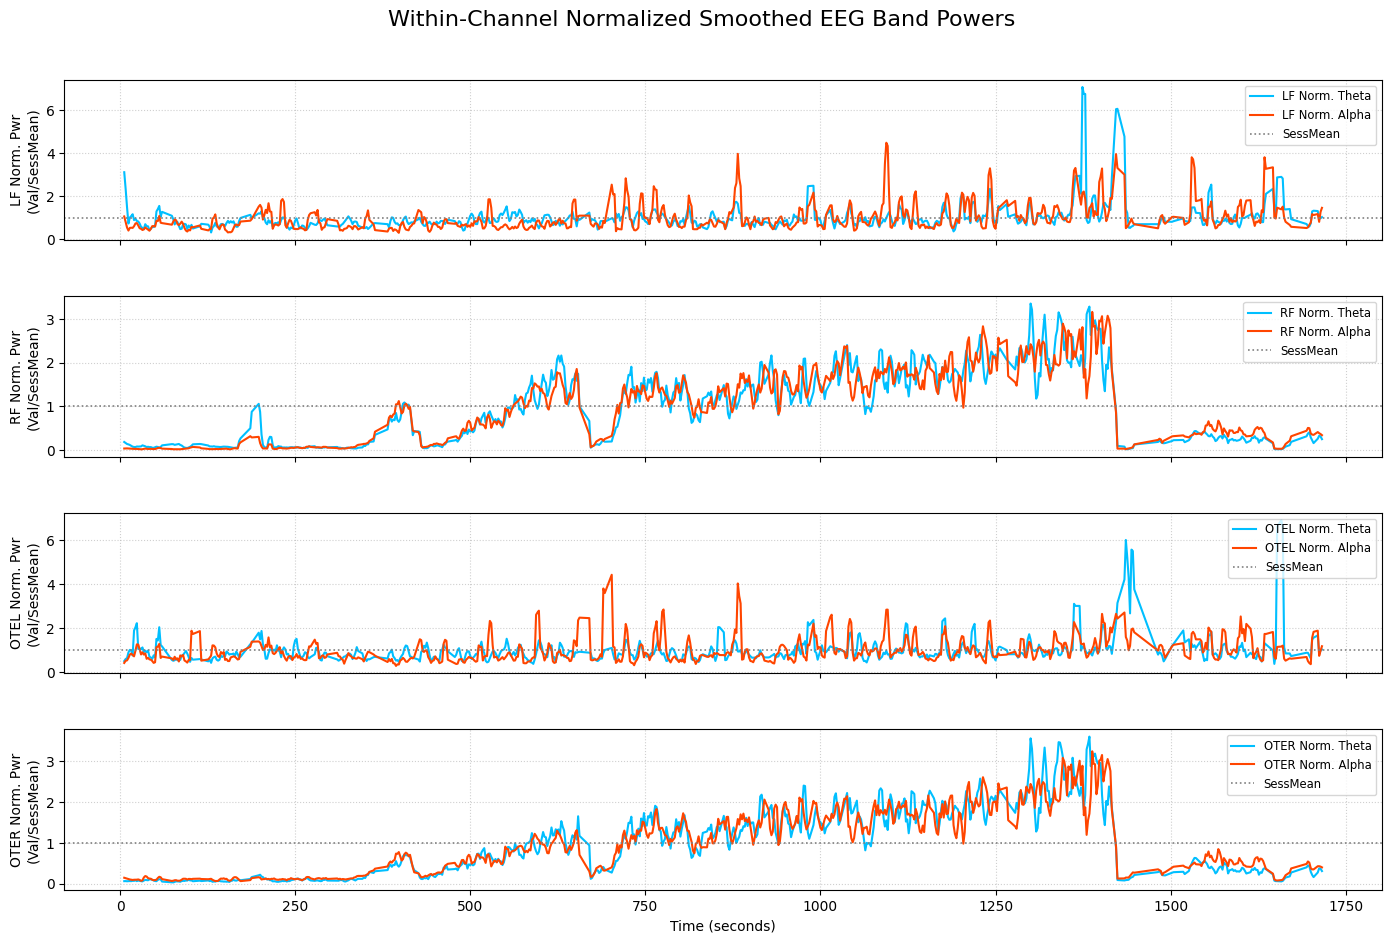

In [2]:
# Cell 5: Calculate and Plot WITHIN-CHANNEL NORMALIZED Smoothed Band Powers

norm_smoothed_band_powers = {name: {band: np.array([]) for band in ['theta', 'alpha']} 
                             for name in EEG_ACTIVE_NAMES}

if 'abs_smoothed_band_powers' in locals() and 'abs_timestamps_power' in locals() and abs_timestamps_power:
    print("Calculating and plotting Within-Channel Normalized Smoothed Band Powers...")
    
    for ch_name_norm in EEG_ACTIVE_NAMES:
        for band_name_norm in ['theta', 'alpha']:
            # Use the ALREADY SMOOTHED absolute powers for normalization
            series_abs_smoothed = abs_smoothed_band_powers[ch_name_norm].get(band_name_norm)
            if series_abs_smoothed is not None and len(series_abs_smoothed) > 0:
                mean_val_norm = np.nanmean(series_abs_smoothed) 
                if mean_val_norm is not np.nan and abs(mean_val_norm) > 1e-9:
                    norm_smoothed_band_powers[ch_name_norm][band_name_norm] = series_abs_smoothed / mean_val_norm
                else:
                    print(f"Warning: Mean for {ch_name_norm} {band_name_norm} is {mean_val_norm}. Norm might be unstable. Filling with NaNs.")
                    norm_smoothed_band_powers[ch_name_norm][band_name_norm] = np.full_like(series_abs_smoothed, np.nan)
            else:
                print(f"Warning: Smoothed absolute power data for {ch_name_norm} {band_name_norm} is missing/empty.")
                norm_smoothed_band_powers[ch_name_norm][band_name_norm] = np.full(len(abs_timestamps_power), np.nan)

    # --- Plotting Normalized Powers ---
    if any(len(data_arr) > 0 for ch_data_dict in norm_smoothed_band_powers.values() for data_arr in ch_data_dict.values()):
        num_eeg_channels_norm_plot = len(EEG_ACTIVE_NAMES)
        fig_norm_power, axs_norm_power = plt.subplots(num_eeg_channels_norm_plot, 1, 
                                                      figsize=(17, 2.5 * num_eeg_channels_norm_plot), 
                                                      sharex=True)
        if num_eeg_channels_norm_plot == 1: axs_norm_power = [axs_norm_power]

        for i_ch_norm, ch_name_norm_plot in enumerate(EEG_ACTIVE_NAMES):
            ax_n = axs_norm_power[i_ch_norm]
            if abs_timestamps_power and len(norm_smoothed_band_powers[ch_name_norm_plot]['theta']) == len(abs_timestamps_power):
                ax_n.plot(abs_timestamps_power, norm_smoothed_band_powers[ch_name_norm_plot]['theta'], 
                        label=f'{ch_name_norm_plot} Norm. Theta', color='deepskyblue', linewidth=1.5)
            if abs_timestamps_power and len(norm_smoothed_band_powers[ch_name_norm_plot]['alpha']) == len(abs_timestamps_power):
                ax_n.plot(abs_timestamps_power, norm_smoothed_band_powers[ch_name_norm_plot]['alpha'], 
                        label=f'{ch_name_norm_plot} Norm. Alpha', color='orangered', linewidth=1.5)
            
            ax_n.set_ylabel(f'{ch_name_norm_plot} Norm. Pwr\n(Val/SessMean)',color='k');ax_n.axhline(1,c='gray',ls=':',lw=1.2,label='SessMean')
            ax_n.legend(loc='upper right',fontsize='small');ax_n.grid(True,ls=':',alpha=0.6)

        if num_eeg_channels_norm_plot > 0:
            axs_norm_power[-1].set_xlabel("Time (seconds)")
            fig_norm_power.suptitle("Within-Channel Normalized Smoothed EEG Band Powers", fontsize=16, y=0.99)
            fig_norm_power.subplots_adjust(top=0.92, hspace=0.35)
            plt.show()
    else:
        print("No valid normalized data to plot.")
else:
    print("Required vars for normalized plot (`abs_smoothed_band_powers`, `abs_timestamps_power`) not found or empty.")

Effective duration of plotted EEG data (from scaled_eeg_data_uv): 1719.02 seconds

Adjusted manual labels DataFrame for First Session (labels_df_manual):
   start_time  end_time  label_numeric label_text
0           0   300.000              0       Rest
1         300   660.000              1      Light
2         660  1420.000              2       Deep
3        1420  1719.024              1      Light

--- Overlaying ADJUSTED manual labels on the NORMALIZED Power plot (First Session) ---
Attempting to overlay label shadings on 4 axes.
Meditation state color legend added. Subplot layout adjusted.
Label overlay process complete.


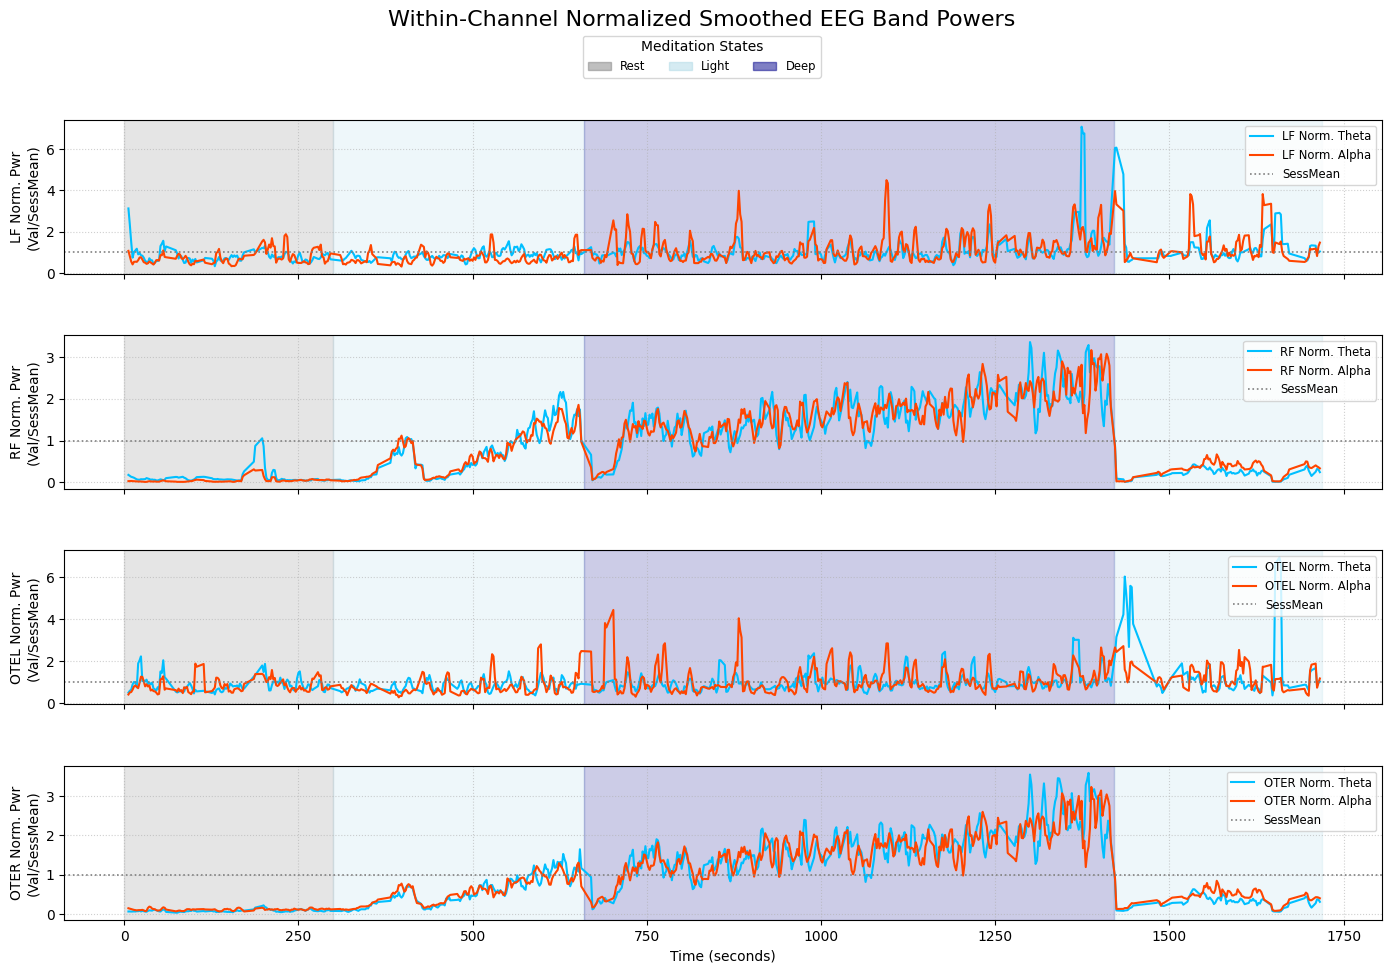


--- Overlaying ADJUSTED manual labels on the ABSOLUTE Power / Ratio plot (First Session) ---
Attempting to overlay label shadings on 4 axes.
Meditation state color legend added. Subplot layout adjusted.
Label overlay process complete.


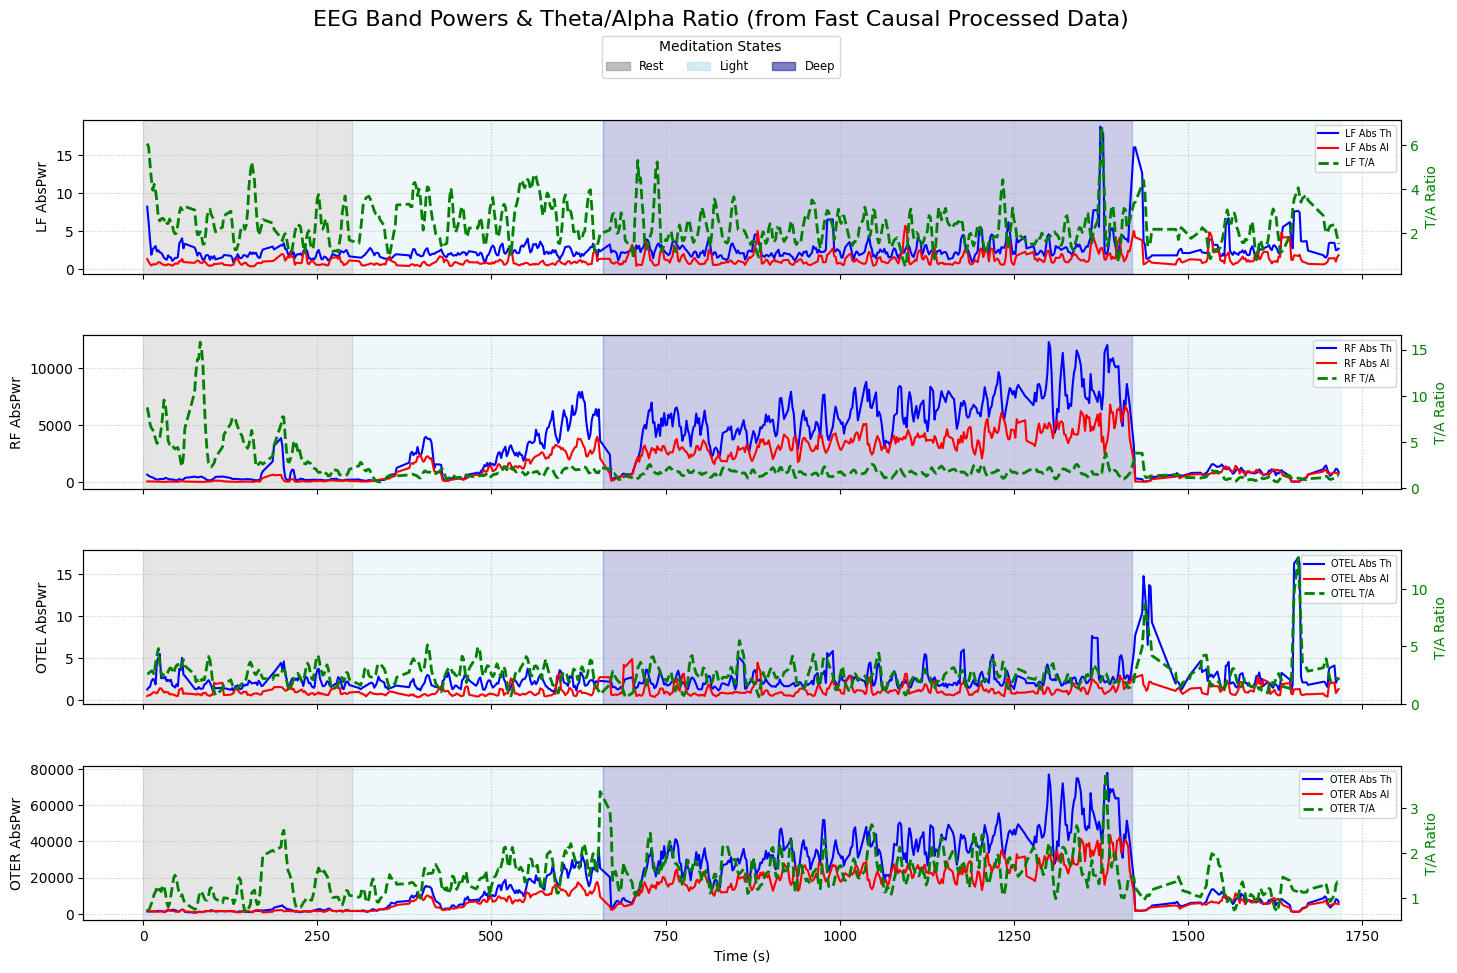

In [3]:
# Cell 6: Define Manual Labels for FIRST SESSION (Adjusted for Trimming) and Overlay

from IPython.display import display # Ensure display is imported
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.axes 
import matplotlib.patches as mpatches 

# --- Original Labeled Data for the FIRST SESSION ---
# These times are relative to the *absolute start* of the original recording.
original_manual_labels_session1 = [
    {'start_time': 0,    'end_time': 360,  'label_numeric': 0, 'label_text': 'Rest'},  # 0-6 min
    {'start_time': 360,  'end_time': 720,  'label_numeric': 1, 'label_text': 'Light'}, # 6-12 min
    {'start_time': 720,  'end_time': 1480, 'label_numeric': 2, 'label_text': 'Deep'},  # 12-28 min
    {'start_time': 1480, 'end_time': 1800, 'label_numeric': 1, 'label_text': 'Light'}  # 28-30 min
    # Assuming the session ends at 30 minutes based on the screenshot data.
    # If it extends further with a 'Rest' or another label, you'll need to add that.
]

# --- Get TRIM_SECONDS_START and TRIM_SECONDS_END ---
# These should be defined in your Cell 2 (Data Loading & Trimming cell)
# If they are not available in 'locals()', provide default values or ensure Cell 2 was run.
if 'TRIM_SECONDS_START' in locals():
    current_trim_start = TRIM_SECONDS_START
else:
    print("Warning: TRIM_SECONDS_START not found in locals. Assuming 30 seconds.")
    current_trim_start = 30 

if 'TRIM_SECONDS_END' in locals():
    current_trim_end = TRIM_SECONDS_END # Not directly used in adjustment from start, but good to be aware of
else:
    print("Warning: TRIM_SECONDS_END not found in locals. Assuming 30 seconds.")
    current_trim_end = 30


# --- Calculate effective data duration of the PLOTTED data (scaled_eeg_data_uv) ---
effective_data_duration_seconds = 0
if 'scaled_eeg_data_uv' in locals() and scaled_eeg_data_uv is not None and 'FS_EEG' in locals():
    effective_data_duration_seconds = scaled_eeg_data_uv.shape[1] / FS_EEG
    print(f"Effective duration of plotted EEG data (from scaled_eeg_data_uv): {effective_data_duration_seconds:.2f} seconds")
else:
    print("Warning: Cannot determine effective data duration from 'scaled_eeg_data_uv'. Labels might not clamp correctly to data end.")
    # As a rough fallback, estimate based on a 20-minute original recording
    estimated_original_duration = 20 * 60 
    effective_data_duration_seconds = estimated_original_duration - current_trim_start - current_trim_end
    print(f"Using estimated effective data duration: {effective_data_duration_seconds:.2f} seconds")


# --- Adjust Label Timestamps for the First Session ---
adjusted_manual_labels_s1 = []
for label_event in original_manual_labels_session1:
    original_start = label_event['start_time']
    original_end = label_event['end_time']

    # Adjust times relative to the start of the trimmed data
    adjusted_start = original_start - current_trim_start
    adjusted_end = original_end - current_trim_start

    # Clamp start time at 0 (relative to trimmed data)
    adjusted_start = max(0, adjusted_start)
    # Clamp end time at the effective duration of the plotted data
    if effective_data_duration_seconds > 0 : # Only clamp if duration is known
        adjusted_end = min(effective_data_duration_seconds, adjusted_end)

    # Only keep the label if there's a valid duration after adjustment
    if adjusted_end > adjusted_start:
        adjusted_manual_labels_s1.append({
            'start_time': adjusted_start,
            'end_time': adjusted_end,
            'label_numeric': label_event['label_numeric'],
            'label_text': label_event['label_text']
        })

labels_df_manual = pd.DataFrame(adjusted_manual_labels_s1) # This df now has adjusted times
print("\nAdjusted manual labels DataFrame for First Session (labels_df_manual):")
if labels_df_manual.empty:
    print("DataFrame is empty. All labels might have been outside the trimmed data range or data duration issue.")
else:
    print(labels_df_manual)


# --- Function to plot labels (This should be the latest corrected version) ---
def plot_manual_labels_on_existing_plot(fig_to_label, axs_to_label, labels_df):
    no_axes = False
    if axs_to_label is None: no_axes = True
    elif isinstance(axs_to_label, (list, np.ndarray)) and len(axs_to_label) == 0: no_axes = True
    
    if labels_df.empty or no_axes:
        print("No labels or no valid axes to plot on."); return
        
    base_color_map_states = {
        'Rest':  (128/255, 128/255, 128/255), 'Light': (173/255, 216/255, 230/255),
        'Deep':  (0/255,   0/255,   139/255), 'default_color': (200/255, 200/255, 200/255)
    }
    
    axes_to_iterate = []
    if isinstance(axs_to_label, matplotlib.axes.Axes): axes_to_iterate = [axs_to_label]
    elif hasattr(axs_to_label, '__iter__'): axes_to_iterate = np.asarray(axs_to_label).flatten()
    else: print("Warning: axs_to_label not recognized for label plotting."); return

    print(f"Attempting to overlay label shadings on {len(axes_to_iterate)} axes.")
    for ax_plot in axes_to_iterate:
        if ax_plot is None: continue
        for _, row in labels_df.iterrows():
            start, end, label_text = row['start_time'], row['end_time'], row['label_text']
            plot_color_rgb = base_color_map_states.get(label_text, base_color_map_states['default_color'])
            ax_plot.axvspan(start, end, alpha=0.2, color=plot_color_rgb, zorder=-1)

    legend_patches = []
    unique_labels_in_data = labels_df['label_text'].unique()
    ordered_states_for_legend = ['Rest', 'Light', 'Deep'] 
    
    for state_name in ordered_states_for_legend:
        if state_name in unique_labels_in_data:
            rgb_color = base_color_map_states.get(state_name)
            if rgb_color: patch = mpatches.Patch(color=rgb_color + (0.5,), label=state_name); legend_patches.append(patch)
    
    for state_name in unique_labels_in_data: 
        is_already_in_legend = any(p.get_label() == state_name for p in legend_patches)
        if not is_already_in_legend and state_name != 'default_color':
            rgb_color = base_color_map_states.get(state_name, base_color_map_states['default_color'])
            patch = mpatches.Patch(color=rgb_color + (0.5,), label=state_name); legend_patches.append(patch)

    if legend_patches and fig_to_label:
        if hasattr(fig_to_label, 'legends'):
            for old_legend in fig_to_label.legends[:]: old_legend.remove()

        fig_to_label.legend(handles=legend_patches, title="Meditation States",
                           loc='upper center', bbox_to_anchor=(0.5, 0.97), 
                           ncol=len(legend_patches), fontsize='small', frameon=True)
        try:
            has_suptitle = fig_to_label._suptitle is not None if hasattr(fig_to_label, '_suptitle') else False
            top_margin = 0.88 if has_suptitle else 0.90 
            current_hspace = 0.4 if (hasattr(axs_to_label, '__len__') and len(axs_to_label) > 1) else 0.1 
            fig_to_label.subplots_adjust(top=top_margin, bottom=0.08, hspace=current_hspace)
            print("Meditation state color legend added. Subplot layout adjusted.")
        except Exception as e: print(f"Note: Could not apply subplots_adjust: {e}")
    
    if fig_to_label: fig_to_label.canvas.draw_idle()
    print("Label overlay process complete.")


# --- Call the function to overlay labels on the plots FROM YOUR FIRST SESSION ---
# Make sure you have run the cells that generate fig_norm_power_s1 / axs_norm_power_s1
# AND/OR fig_abs_ratio_s1 / axs_abs_ratio_s1 for the FIRST SESSION's data.

# OPTION 1: Overlay on the NORMALIZED plot for the FIRST session
# (Assuming you named the figure for the first session's normalized plot fig_norm_power_s1)
if 'fig_norm_power' in locals() and fig_norm_power is not None and \
   'axs_norm_power' in locals() and axs_norm_power is not None:
    print("\n--- Overlaying ADJUSTED manual labels on the NORMALIZED Power plot (First Session) ---")
    plot_manual_labels_on_existing_plot(fig_norm_power, axs_norm_power, labels_df_manual)
    display(fig_norm_power) 
else:
    print("Plot for NORMALIZED powers ('fig_norm_power') for the First Session not found. Cannot overlay labels.")
    print("ACTION: Re-run the cell that generates 'fig_norm_power' for the First Session.")

# OPTION 2: Overlay on the ABSOLUTE power and ratio plot for the FIRST session
# (Assuming you named the figure for the first session's absolute plot fig_abs_ratio_s1)
if 'fig_abs_ratio' in locals() and fig_abs_ratio is not None and \
   'axs_abs_ratio' in locals() and axs_abs_ratio is not None:
    print("\n--- Overlaying ADJUSTED manual labels on the ABSOLUTE Power / Ratio plot (First Session) ---")
    plot_manual_labels_on_existing_plot(fig_abs_ratio, axs_abs_ratio, labels_df_manual)
    display(fig_abs_ratio)
else:
    print("\nPlot for ABSOLUTE powers/ratios ('fig_abs_ratio') for the First Session not found. Cannot overlay labels.")
    print("ACTION: Re-run the cell that generates 'fig_abs_ratio' for the First Session.")